# Linear Regression — Power Plant Dataset (Univariate → Multivariate)

This notebook is designed to **match the lecture flow**:

- **Univariate Linear Regression**: model, cost (MSE), gradient descent intuition
- **Multivariate Linear Regression**: multiple features, feature normalization, learning rate
- **Normal Equation vs Gradient Descent**: two ways to solve the same problem



---
### Dataset Variable Descriptions
Dataset: `Power_plant.csv` (Combined Cycle Power Plant)  
Features: `AT`, `V`, `AP`, `RH`  
Target: **`PE`** (net electrical energy output)

The dataset contains 9,568 data points collected from a Combined Cycle Power Plant over 6 years (2006-2011).

| Variable Name | Full Name | Role | Type | Units | Description / Range |
| :--- | :--- | :--- | :--- | :--- | :--- |
| **AT** | Temperature | Feature | Continuous | °C | Hourly average ambient temperature. Range: 1.81°C – 37.11°C. |
| **V** | Exhaust Vacuum | Feature | Continuous | cm Hg | Hourly average exhaust vacuum. Range: 25.36 – 81.56 cm Hg. |
| **AP** | Ambient Pressure | Feature | Continuous | millibar | Hourly average ambient pressure. Range: 992.89 – 1033.30 millibar. |
| **RH** | Relative Humidity | Feature | Continuous | % | Hourly average relative humidity. Range: 25.56% – 100.16%. |
| **PE** | Power Output | Target | Continuous | MW | Net hourly electrical energy output. Range: 420.26 – 495.76 MW. |

In [1]:
# =========================
# 0) Setup
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Optional (interactive sliders)
try:
    import ipywidgets as widgets
    from ipywidgets import interact
    HAS_WIDGETS = True
except Exception:
    HAS_WIDGETS = False

print("Widgets available:", HAS_WIDGETS)


Widgets available: True


In [2]:
# =========================
# 1) Load dataset
# =========================
df = pd.read_csv("Power_plant.csv")
df.head()


,AT,V,AP,RH,PE
0,8.34,40.77,1010.84,90.01,480.48
1,23.64,58.49,1011.40,74.20,445.75
2,29.74,56.90,1007.15,41.91,438.76
3,19.07,49.69,1007.22,76.79,453.09
4,11.80,40.66,1017.13,97.20,464.43


In [3]:
df.shape, df.columns


((9568, 5), Index(['AT', 'V', 'AP', 'RH', 'PE'], dtype='object'))

## 1.1 Quick sanity checks

For any ML dataset, always check:
- summary statistics (ranges)
- missing values
- correlations (optional, for intuition)


In [4]:
df.describe().T


,count,mean,std,min,25%,50%,75%,max
AT,9568.0,19.651231,7.452473,1.81,13.5100,20.345,25.72,37.11
V,9568.0,54.305804,12.707893,25.36,41.7400,52.080,66.54,81.56
AP,9568.0,1013.259078,5.938784,992.89,1009.1000,1012.940,1017.26,1033.30
RH,9568.0,73.308978,14.600269,25.56,63.3275,74.975,84.83,100.16
PE,9568.0,454.365009,17.066995,420.26,439.7500,451.550,468.43,495.76


In [5]:
df.isna().sum()


AT    0
V     0
AP    0
RH    0
PE    0
dtype: int64

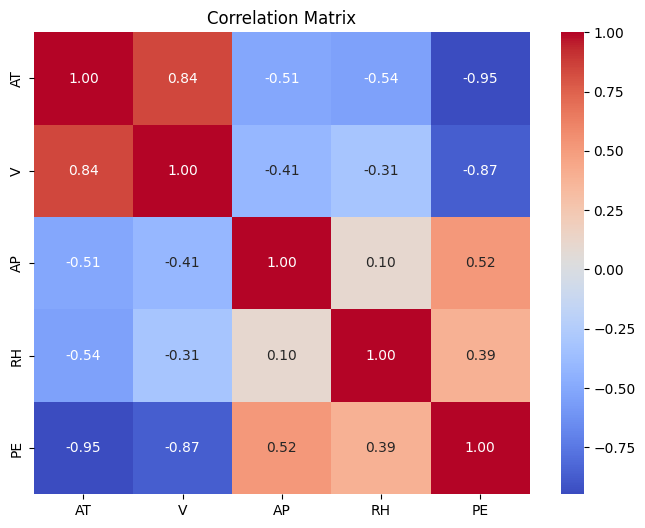

In [6]:
df.corr(numeric_only=True)
# Show as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


### seaborn pairwise plot
Use `sns.pairplot` to quickly visualize relationships between features and target. Look for:
- Linear relationships between each feature and the target variable `PE`.
- Any potential outliers or non-linear patterns. 

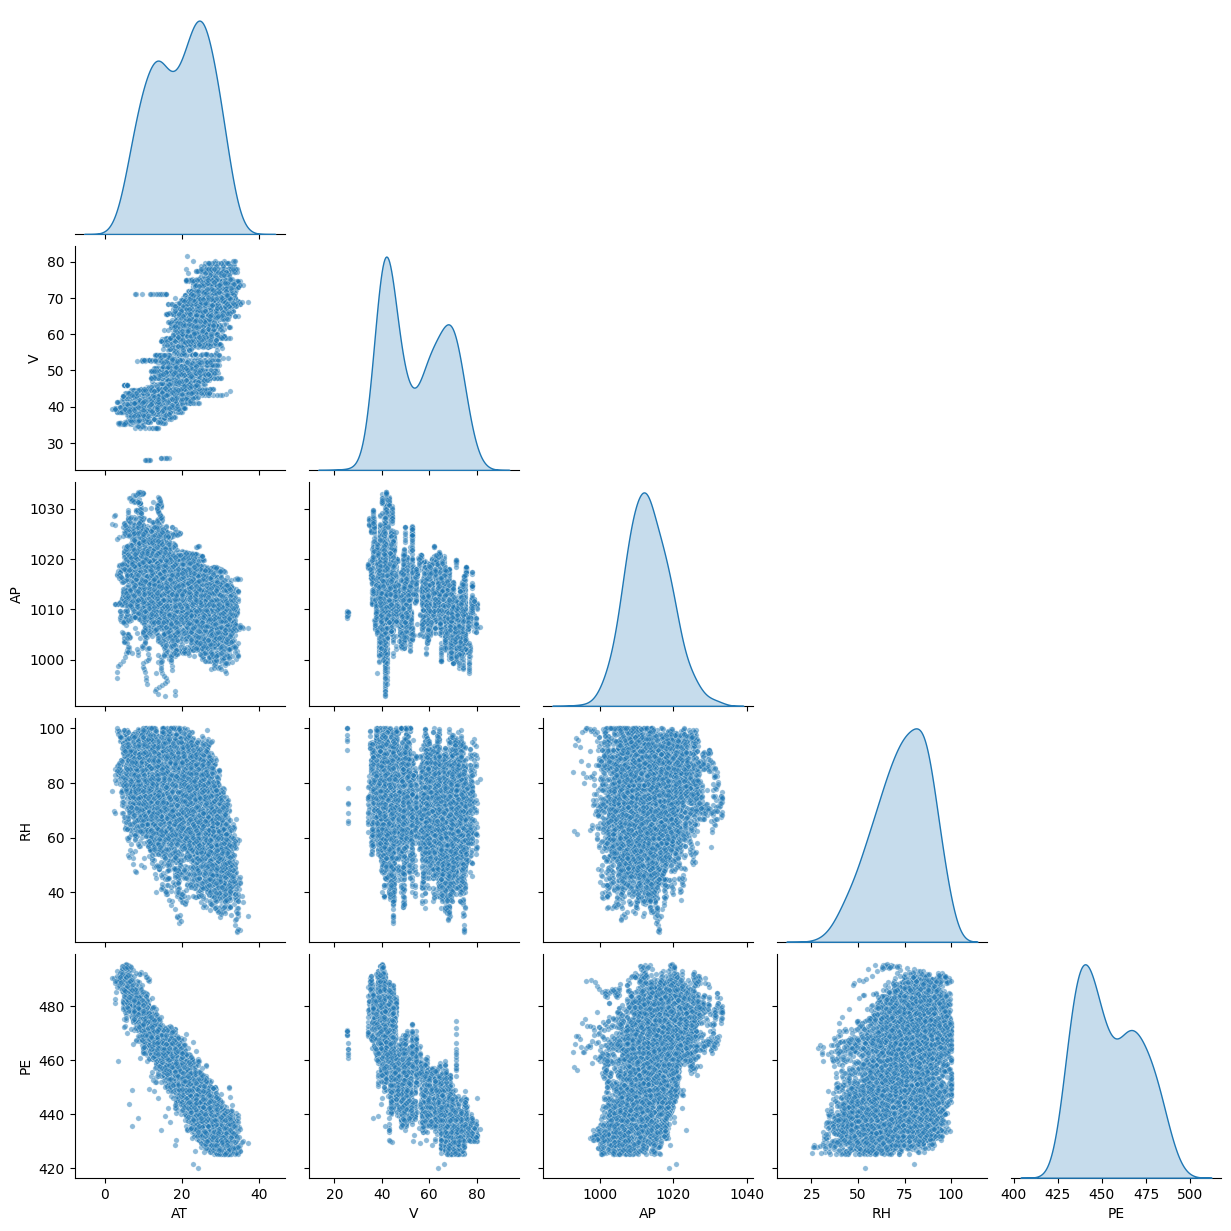

In [18]:
# Make pairplot to visualize relationships
# Use normal seaborn style for faster plotting

do_fast_plot = True

if do_fast_plot:
    # sns.pairplot(df, corner=True, height=2.5)
    # plt.suptitle("Pairwise Relationships (All Features)", y=1.02, fontsize=16, fontweight='bold')
    # plt.show()  

    sns.pairplot(
        df,               # Din (gärna samplade) data
        corner=True,      # Sparar prestanda genom att bara visa halva matrisen
        height=2.5,
        diag_kind="kde",  # <--- Tvingar fram kurvor på diagonalen
        plot_kws={'s': 15, 'alpha': 0.5}, # Gör punkterna mindre/genomskinliga för snabbhet
        diag_kws={'bw_adjust': 2.0}       # <--- VIKTIGT: Gör kurvan mjukare om du har lite data
    )
    plt.show()
    

else:

    # ========================= Heavy pairplotting =========================
    X, y = df.drop(columns=['PE']).values, df['PE'].values

    # 1. Skapa kolumnnamn dynamiskt baserat på hur många features
    num_features = X.shape[1]
    col_names = [f"Feature {i+1}" for i in range(num_features)]

    # 2. Skapa DataFrame
    df_sns = pd.DataFrame(X, columns=col_names)
    df_sns['Class'] = y 

    # 3. Plotting (Projector Safe Style)
    custom_colors = ["#00008B", "#CC0000"] 
    custom_markers = ["o", "^"] if len(set(y)) == 2 else None # Använd markörer om det är 2 klasser

    sns.pairplot(
        df_sns,
        hue="Class",
        palette=custom_colors if len(set(y)) == 2 else "bright",
        markers=custom_markers,
        corner=True,
        height=2.5,
        plot_kws={'s': 80, 'edgecolor': 'white', 'alpha': 0.9}
    )

    plt.suptitle(f"Pairwise Relationships ({num_features} Features)", y=1.02, fontsize=16, fontweight='bold')
    plt.show()

# Part A — Univariate Linear Regression
### **Ambient Temperature $\rightarrow$ Power Output (AT → PE)**

We start with a single input feature:

$$
\hat{y} = h_\theta(x) = \theta_0 + \theta_1 x
$$

Here:
- $x = AT$ (ambient temperature)
- $y = PE$ (power output)

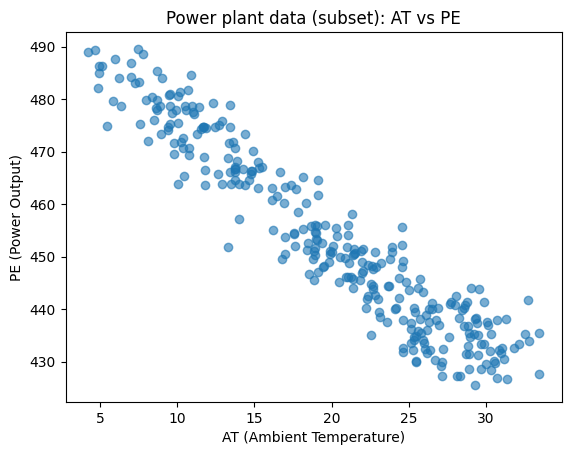

In [ ]:
x = df[["AT"]].to_numpy()
y = df["PE"].to_numpy()

n_plot = 300
idx = np.random.choice(len(df), size=n_plot, replace=False)

plt.figure()
plt.scatter(x[idx, 0], y[idx], alpha=0.6)
plt.xlabel("AT (Ambient Temperature)")
plt.ylabel("PE (Power Output)")
plt.title("Power plant data (subset): AT vs PE")
plt.show()


## A1 — Fit a line using least squares (scikit-learn)

`LinearRegression()` solves least squares.

We evaluate with:
- **MSE** (Mean Squared Error): lower is better
- **R²**: closer to 1 is better


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.30, random_state=RANDOM_STATE
)

lin_uni = LinearRegression()
lin_uni.fit(X_train, y_train)

print("Intercept (theta0):", lin_uni.intercept_)
print("Slope (theta1):", lin_uni.coef_[0])

pred = lin_uni.predict(X_test)
print("Test MSE:", mean_squared_error(y_test, pred))
print("Test R^2:", r2_score(y_test, pred))


Intercept (theta0): 496.9722066569078
Slope (theta1): -2.1707489124208332
Test MSE: 28.75957098562728
Test R^2: 0.9001289373931998


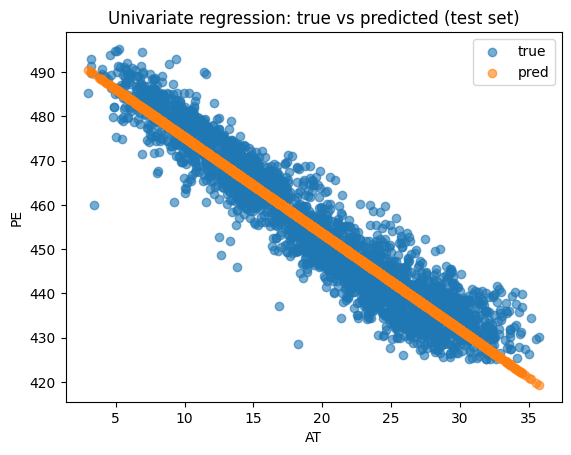

In [ ]:
plt.figure()
plt.scatter(X_test[:,0], y_test, alpha=0.6, label="true")
plt.scatter(X_test[:,0], pred, alpha=0.6, label="pred")
plt.xlabel("AT")
plt.ylabel("PE")
plt.title("Univariate regression: true vs predicted (test set)")
plt.legend()
plt.show()


## A2 — Cost function (MSE) and residuals

MSE cost:

$$
J(\theta_0,\theta_1)=\frac{1}{m}\sum_{i=1}^m(\hat{y}^{(i)}-y^{(i)})^2
$$

Residuals:

$$
r^{(i)}=\hat{y}^{(i)}-y^{(i)}
$$


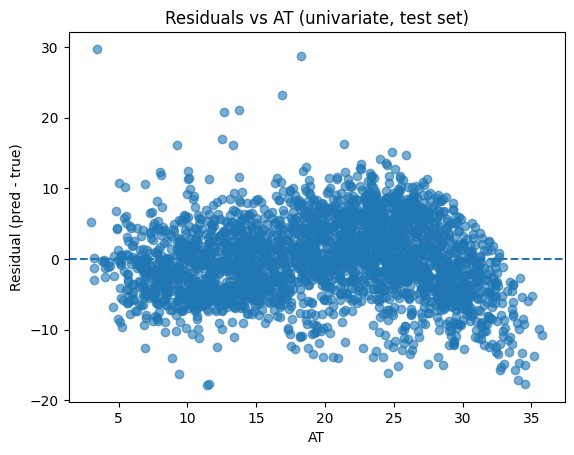

Residual mean: -0.16893627719605253
Residual std: 5.360133535638307


In [ ]:
residuals = pred - y_test

plt.figure()
plt.scatter(X_test[:,0], residuals, alpha=0.6)
plt.axhline(0, linestyle="--")
plt.xlabel("AT")
plt.ylabel("Residual (pred - true)")
plt.title("Residuals vs AT (univariate, test set)")
plt.show()

print("Residual mean:", residuals.mean())
print("Residual std:", residuals.std())


## A3 — Gradient Descent from scratch (iterative learning)

Update rule:

$$
\theta \leftarrow \theta - \alpha \nabla_\theta J(\theta)
$$

For univariate MSE with $\hat{y}=\theta_0+\theta_1 x$:

$$
\frac{\partial J}{\partial \theta_0}=\frac{2}{m}\sum_i (\hat{y}^{(i)}-y^{(i)}), \quad
\frac{\partial J}{\partial \theta_1}=\frac{2}{m}\sum_i (\hat{y}^{(i)}-y^{(i)})x^{(i)}
$$


In [ ]:
def gd_univariate(x_vec, y_vec, alpha=1e-4, n_steps=4000, theta0=0.0, theta1=0.0):
    m = len(x_vec)
    history = np.zeros(n_steps)
    for t in range(n_steps):
        y_hat = theta0 + theta1 * x_vec
        err = y_hat - y_vec
        d0 = (2/m) * np.sum(err)
        d1 = (2/m) * np.sum(err * x_vec)
        theta0 -= alpha * d0
        theta1 -= alpha * d1
        history[t] = np.mean(err**2)
    return theta0, theta1, history

x_tr = X_train[:,0]
y_tr = y_train

theta0_gd, theta1_gd, hist = gd_univariate(x_tr, y_tr, alpha=1e-4, n_steps=4000)

print("GD theta0:", theta0_gd)
print("GD theta1:", theta1_gd)
print("Least squares theta0:", lin_uni.intercept_)
print("Least squares theta1:", lin_uni.coef_[0])


GD theta0: 48.607484966630345
GD theta1: 17.79909406165992
Least squares theta0: 496.9722066569078
Least squares theta1: -2.1707489124208332


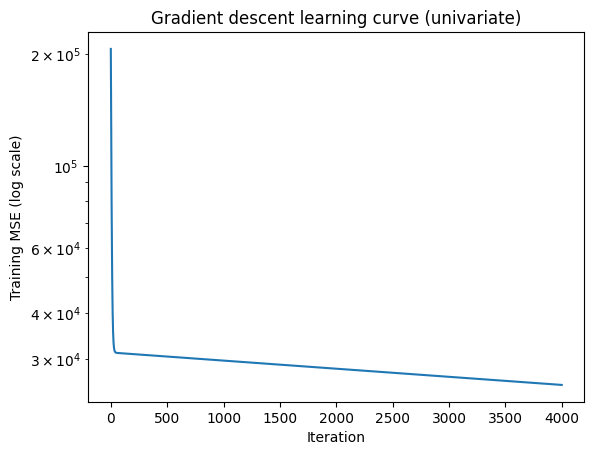

GD Test MSE: 24882.610836985103


In [ ]:
plt.figure()
plt.plot(hist)
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Training MSE (log scale)")
plt.title("Gradient descent learning curve (univariate)")
plt.show()

pred_gd = theta0_gd + theta1_gd * X_test[:,0]
print("GD Test MSE:", mean_squared_error(y_test, pred_gd))


### A3.1 Learning rate demo (optional)


In [ ]:
if HAS_WIDGETS:
    def demo_univariate_lr(alpha=1e-4, steps=2000):
        t0, t1, h = gd_univariate(x_tr, y_tr, alpha=float(alpha), n_steps=int(steps))
        plt.figure()
        plt.plot(h)
        plt.yscale("log")
        plt.xlabel("Iteration")
        plt.ylabel("Train MSE (log)")
        plt.title(f"Univariate GD: alpha={alpha}")
        plt.show()

        pred_tmp = t0 + t1 * X_test[:,0]
        print(f"theta0={t0:.3f}, theta1={t1:.3f}, test MSE={mean_squared_error(y_test, pred_tmp):.3f}")

    interact(
        demo_univariate_lr,
        alpha=widgets.FloatLogSlider(value=1e-4, base=10, min=-6, max=-2, step=0.2, description="alpha"),
        steps=widgets.IntSlider(value=2000, min=200, max=12000, step=200, description="steps"),
    )
else:
    print("ipywidgets not available; skip interactive demo.")


interactive(children=(FloatLogSlider(value=0.0001, description='alpha', max=-2.0, min=-6.0, step=0.2), IntSlid…

---

# Part B — Multivariate Linear Regression (AT, V, AP, RH → PE)

Model:

$$
\hat{y} = \theta_0 + \theta_1 AT + \theta_2 V + \theta_3 AP + \theta_4 RH
$$

We compare:
- Univariate baseline (AT only)
- Multivariate (all features)


In [ ]:
X = df[["AT","V","AP","RH"]].to_numpy()
y = df["PE"].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=RANDOM_STATE
)

lin_uni2 = LinearRegression().fit(X_train[:, [0]], y_train)
pred_uni2 = lin_uni2.predict(X_test[:, [0]])

lin_multi = LinearRegression().fit(X_train, y_train)
pred_multi = lin_multi.predict(X_test)

def report(name, y_true, y_pred):
    print(f"{name:>12} | MSE={mean_squared_error(y_true,y_pred):9.3f} | R^2={r2_score(y_true,y_pred):6.3f}")

report("Univariate", y_test, pred_uni2)
report("Multivariate", y_test, pred_multi)


  Univariate | MSE=   28.760 | R^2= 0.900
Multivariate | MSE=   20.002 | R^2= 0.931


## B1 — Coefficients (raw units)

Coefficient = expected change in `PE` for a +1 change in feature, holding other features fixed.

Because units differ, coefficient magnitudes are not directly comparable without scaling.


In [ ]:
coef = pd.Series(lin_multi.coef_, index=["AT","V","AP","RH"])
coef


AT   -1.984604
V    -0.231469
AP    0.055961
RH   -0.159738
dtype: float64

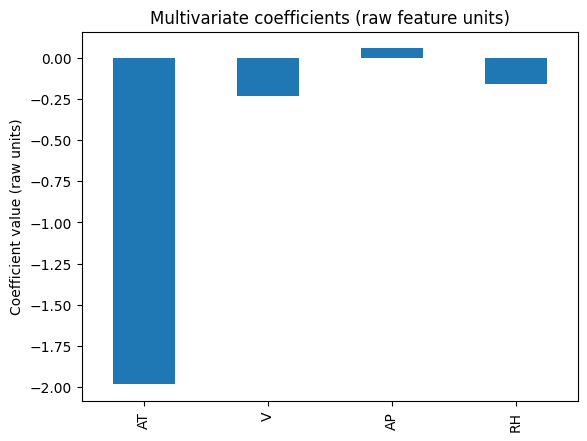

Intercept: 460.94747177326855


In [ ]:
plt.figure()
coef.plot(kind="bar")
plt.ylabel("Coefficient value (raw units)")
plt.title("Multivariate coefficients (raw feature units)")
plt.show()

print("Intercept:", lin_multi.intercept_)


---

# Part C — Feature normalization & gradient descent stability

Feature normalization (Z-score):

$$
x' = \frac{x-\mu}{\sigma}
$$

We implement batch gradient descent for the multivariate case and compare:
- without scaling (often needs tiny learning rate)
- with scaling (usually faster, stable)


In [ ]:
def add_bias(X):
    return np.c_[np.ones((X.shape[0], 1)), X]

def gd_multivariate(X, y, alpha=1e-3, n_steps=5000):
    Xb = add_bias(X)
    m, n = Xb.shape
    theta = np.zeros(n)
    history = np.zeros(n_steps)

    for t in range(n_steps):
        y_hat = Xb @ theta
        err = y_hat - y
        grad = (2/m) * (Xb.T @ err)
        theta = theta - alpha * grad
        history[t] = np.mean(err**2)
    return theta, history


In [ ]:
theta_raw, hist_raw = gd_multivariate(X_train, y_train, alpha=1e-7, n_steps=8000)
pred_raw = add_bias(X_test) @ theta_raw
print("GD (raw features) test MSE:", mean_squared_error(y_test, pred_raw))


GD (raw features) test MSE: 140.63270084116934


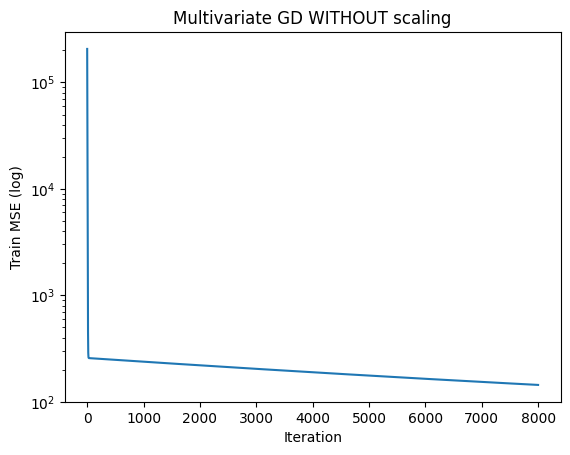

In [ ]:
plt.figure()
plt.plot(hist_raw)
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Train MSE (log)")
plt.title("Multivariate GD WITHOUT scaling")
plt.show()


In [ ]:
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

theta_s, hist_s = gd_multivariate(X_train_s, y_train, alpha=1e-2, n_steps=4000)
pred_s = add_bias(X_test_s) @ theta_s

print("GD (scaled) test MSE:", mean_squared_error(y_test, pred_s))
print("Least squares (sklearn) test MSE:", mean_squared_error(y_test, pred_multi))


GD (scaled) test MSE: 20.001860879529968
Least squares (sklearn) test MSE: 20.001993364332083


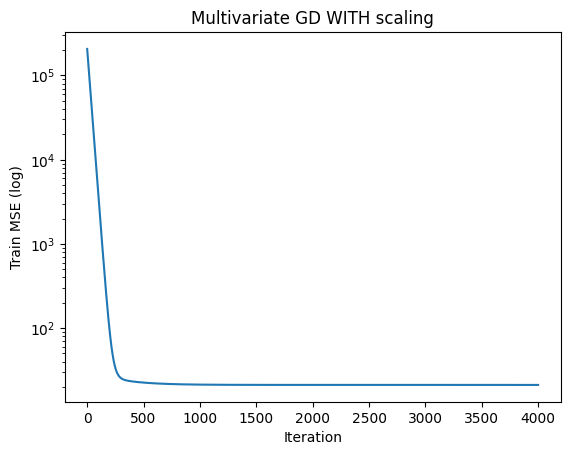

In [ ]:
plt.figure()
plt.plot(hist_s)
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Train MSE (log)")
plt.title("Multivariate GD WITH scaling")
plt.show()


## Comparison: scaling with Z-score — final model vs optimization behavior

We compare the models we already trained earlier:

- **Ordinary Least Squares (OLS) (closed-form)**: `pred_multi`
- **Gradient Descent (GD) without scaling**: `pred_raw` and learning curve `hist_raw`
- **Gradient Descent (GD) with Z-score scaling**: `pred_s` and learning curve `hist_s`

**What we quantify**
- Test **MSE** and **R²** for each model (same test set)
- How close GD predictions are to OLS predictions (MAE and max absolute difference)

**What we visualize**
- Bar chart of test MSE (final performance)
- Learning curves (train MSE vs iteration) to show how scaling affects convergence

Interpretation:
- With ordinary least squares (no regularization), Z-score scaling should not change the *best achievable* linear model,
  but it can drastically change how fast/stable gradient descent gets there.


,Test MSE,Test R2
Model,,
OLS (LinearRegression),20.001993,0.930541
GD (raw features),140.632701,0.511636
GD (Z-score scaled),20.001861,0.930541


,"MAE(pred, OLS)",Max|pred-OLS|
GD (raw features),9.499402,32.781231
GD (Z-score scaled),0.000712,0.004435


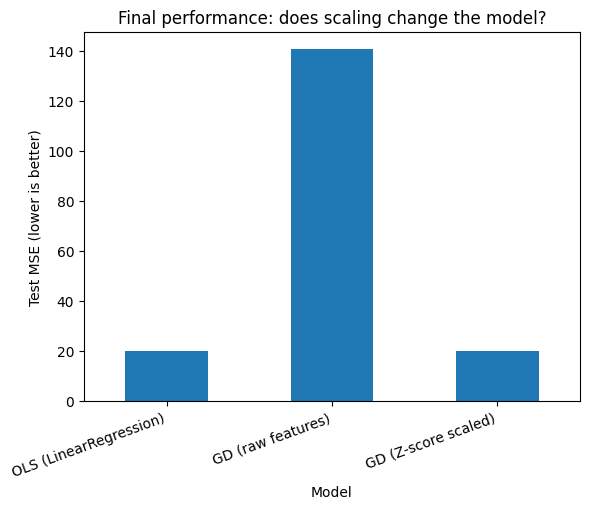

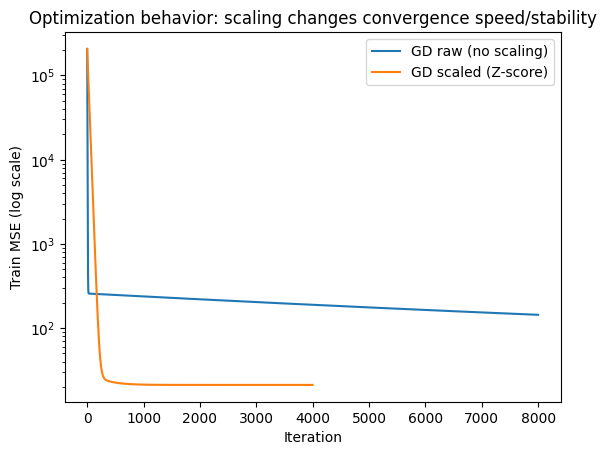

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# -----
# 0) Verify required variables exist (from previous cells)
# -----
required = [
    "y_test",        # test targets
    "pred_multi",    # sklearn LinearRegression predictions (multivariate)
    "pred_raw",      # GD predictions without scaling
    "pred_s",        # GD predictions with scaling
    "hist_raw",      # GD training MSE history (raw)
    "hist_s"         # GD training MSE history (scaled)
]
missing = [v for v in required if v not in globals()]
if missing:
    raise RuntimeError(
        "Missing objects from earlier cells:\n"
        f"{missing}\n\n"
        "Run the earlier training cells that define these variables first."
    )

# -----
# 1) Quantify: metrics table
# -----
def metrics(y_true, y_pred):
    return mean_squared_error(y_true, y_pred), r2_score(y_true, y_pred)

rows = []
for name, pred in [
    ("OLS (LinearRegression)", pred_multi),
    ("GD (raw features)", pred_raw),
    ("GD (Z-score scaled)", pred_s),
]:
    mse, r2 = metrics(y_test, pred)
    rows.append([name, mse, r2])

metrics_df = pd.DataFrame(rows, columns=["Model", "Test MSE", "Test R2"]).set_index("Model")
display(metrics_df)

# -----
# 2) Quantify: "same model?" check (compare predictions to OLS baseline)
# -----
diff_df = pd.DataFrame({
    "MAE(pred, OLS)": [
        np.mean(np.abs(pred_raw - pred_multi)),
        np.mean(np.abs(pred_s - pred_multi)),
    ],
    "Max|pred-OLS|": [
        np.max(np.abs(pred_raw - pred_multi)),
        np.max(np.abs(pred_s - pred_multi)),
    ],
}, index=["GD (raw features)", "GD (Z-score scaled)"])
display(diff_df)

# -----
# 3) Visualize: test MSE comparison (final performance)
# -----
plt.figure()
metrics_df["Test MSE"].plot(kind="bar")
plt.ylabel("Test MSE (lower is better)")
plt.title("Final performance: does scaling change the model?")
plt.xticks(rotation=20, ha="right")
plt.show()

# -----
# 4) Visualize: learning curves (optimization behavior)
# -----
plt.figure()
plt.plot(hist_raw, label="GD raw (no scaling)")
plt.plot(hist_s, label="GD scaled (Z-score)")
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Train MSE (log scale)")
plt.title("Optimization behavior: scaling changes convergence speed/stability")
plt.legend()
plt.show()


### C1 Learning rate demo (optional)


In [ ]:
if HAS_WIDGETS:
    def demo_multi_lr(alpha=1e-2, steps=2000):
        theta, hist = gd_multivariate(X_train_s, y_train, alpha=float(alpha), n_steps=int(steps))
        plt.figure()
        plt.plot(hist)
        plt.yscale("log")
        plt.xlabel("Iteration")
        plt.ylabel("Train MSE (log)")
        plt.title(f"Scaled multivariate GD: alpha={alpha}")
        plt.show()

        pred_tmp = add_bias(X_test_s) @ theta
        print(f"test MSE={mean_squared_error(y_test, pred_tmp):.3f}")

    interact(
        demo_multi_lr,
        alpha=widgets.FloatLogSlider(value=1e-2, base=10, min=-4, max=0, step=0.2, description="alpha"),
        steps=widgets.IntSlider(value=2000, min=200, max=12000, step=200, description="steps"),
    )
else:
    print("ipywidgets not available; skip interactive demo.")


interactive(children=(FloatLogSlider(value=0.01, description='alpha', max=0.0, min=-4.0, step=0.2), IntSlider(…

---

# Part D — Normal equation vs gradient descent

Normal equation (closed-form):

$$
\theta = (X^T X)^{-1} X^T y
$$

We compute it directly and compare to `LinearRegression()`.


In [ ]:
def normal_equation(X, y, ridge_lambda=0.0):
    Xb = add_bias(X)
    n = Xb.shape[1]
    I = np.eye(n)
    I[0,0] = 0.0  # don't regularize bias
    theta = np.linalg.pinv(Xb.T @ Xb + ridge_lambda * I) @ (Xb.T @ y)
    return theta

theta_ne = normal_equation(X_train, y_train, ridge_lambda=0.0)
pred_ne = add_bias(X_test) @ theta_ne
print("Normal equation test MSE:", mean_squared_error(y_test, pred_ne))


Normal equation test MSE: 20.001993362503676


In [ ]:
theta_sklearn = np.r_[lin_multi.intercept_, lin_multi.coef_]
pd.DataFrame(
    {"normal_eq": theta_ne, "sklearn": theta_sklearn},
    index=["bias","AT","V","AP","RH"]
)


,normal_eq,sklearn
bias,460.947470,460.947472
AT,-1.984604,-1.984604
V,-0.231469,-0.231469
AP,0.055961,0.055961
RH,-0.159738,-0.159738


# Summary (what to remember)

- Univariate regression fits a **line**; multivariate regression fits a **hyperplane**
- Least squares gives a closed-form optimum (normal equation / linear algebra)
- Gradient descent depends strongly on:
  - **learning rate**
  - **feature scale**
- Feature normalization often makes optimization much faster and more stable
